# Speech commands model predictions on real data and model quantization (Tutorial)

In this post, we want to see if the speech commands recognition model we trained in the [previous post](https://jumpml.com/tutorial-pytorch-speechcommands/output/) actually works on real recorded data. 

In addition we will learn how to quantize weights in PyTorch. This will help make the model smaller and potentially faster for prediction. Performance may or may not get worse. 

This notebook is available on github at this [link](https://github.com/jumpml/pytorch-tutorials/blob/master/SpeechCommands_CNN_quantize.ipynb). 

In [1]:
# CUSTOMARY IMPORTS
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import os

from jumpml import models
from jumpml import eval
from jumpml import SpeechCommandsDataset as scd
from jumpml import utils

import itertools
from IPython.display import Audio

import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 1        
torch.manual_seed(random_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', device)

Using cpu


In [2]:
# Quantization needs PyTorch version 1.6.0, so please update if needed.
print(torch.__version__)

1.6.0


In [3]:
batch_size_train = 64
# Setup train, val and test dataloaders
sc_data = scd.SpeechCommandsData(train_bs=batch_size_train, test_bs=256, val_bs=256, n_mels=64)

Found existing background directory. Removing files in that directory.
Initialize/download SpeechCommandsDataset....

SpeechCommands Dataset Size: 105829

Generate 1s background files:

Background files generated: 280

Extracting training dataset files...
Train dataset extracted: 84843 files 

Extracting test and val dataset files...
Validation dataset extracted: 9981 files
Test dataset extracted: 11005 files


## Model Loading
In a previous post, we trained a simple CNN model to recognize speech commands. We will load the same exact model with the same input size, kernel sizes, layers, etc. There are two steps in model loading  
1. Model instantiation: this is the skeleton with space for the parameters
2. Parameter loading from a previously saved .pt file 


In [4]:
PATH = "./models/speech_commands_model.pt"
nnModel = models.SpeechCommandsModel().to(device)       # Instantiate our model and move model to GPU if available
nnModel.load_state_dict(torch.load(PATH, map_location=torch.device(device)))
nnModel.eval()

SpeechCommandsModel(
  (conv1): Conv2d(1, 32, kernel_size=(8, 20), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 8, kernel_size=(4, 10), stride=(1, 1))
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1536, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=11, bias=True)
)

## Model Quantization
As of PyTorch 1.6.0, there are three ways to quantize a model 
1. Dynamic Quantization: quantized weights applied post-training 
2. Static Quantization: fuses layers like BatchNorm and Relu, uses data for calibration applied post-training
3. Quantization-aware training: static quantization during training

We will try out the easiest one, dynamic quantization, which I am just going to call weight quantization. Basically we need to tell the quantizer which layers we want to quantize, for e.g. nn.Linear usually has a lot of parameters and is a prime candidate for weight quantization and what the target data type is. Since parameters are float32, the two options available are float16 or qint8. We will convert Conv2d and Linear layers to 8-bit parameters.

In [5]:
quantized_model = torch.quantization.quantize_dynamic(
    nnModel, {nn.Conv2d, nn.Linear}, dtype=torch.qint8)

In [6]:
utils.print_size_of_model(nnModel)
utils.print_size_of_model(quantized_model)

Size (MB): 0.864021
Size (MB): 0.271357


In [7]:
lossFn = F.nll_loss  #When we combine nll_loss and log_softmax we get a cross entropy loss
evalSC = eval.evalModel(nnModel, lossFn, device)
evalSCq = eval.evalModel(quantized_model, lossFn, device)
evalSC.evalClass(sc_data.test_loader)


Avg. loss: 0.0007, Accuracy: 94.42631530761719 %  Elapsed Time=126.23865580558777



(tensor(94.4263),
 array([[ 393,    0,    0,    2,    6,    0,    0,    0,    0,    1,    4],
        [   0,  357,    0,   17,    0,    0,    0,    0,    0,   16,   23],
        [   0,    3,  390,    0,    1,    0,    1,   14,    4,    2,   15],
        [   0,    3,    0,  336,    0,    0,    0,    0,    0,    5,   11],
        [   3,    0,    0,    1,  369,    1,    0,    0,    0,    1,   22],
        [   0,    0,    0,    0,    2,  360,    0,    0,    0,    0,   16],
        [   0,    0,    2,    0,    0,    0,  337,    9,    0,    0,   24],
        [   0,    0,    6,    0,    0,    0,   14,  353,    1,    1,   16],
        [   0,    0,    3,    1,    0,    0,    0,    1,  393,    1,    8],
        [   0,    7,    0,   10,    0,    0,    2,    3,    0,  329,   19],
        [  23,   35,   24,   39,   34,   35,   42,   22,   13,   46, 6802]]))

In [8]:
evalSCq.evalClass(sc_data.test_loader)


Avg. loss: 0.0007, Accuracy: 94.39006805419922 %  Elapsed Time=36.33142900466919



(tensor(94.3901),
 array([[ 393,    0,    0,    2,    5,    0,    0,    0,    0,    1,    4],
        [   0,  357,    0,   16,    0,    0,    0,    0,    0,   16,   23],
        [   0,    3,  390,    0,    1,    0,    1,   16,    4,    2,   15],
        [   0,    3,    0,  336,    0,    0,    0,    0,    0,    5,   10],
        [   3,    0,    0,    1,  369,    1,    0,    0,    0,    1,   22],
        [   0,    0,    0,    0,    2,  359,    0,    0,    0,    0,   17],
        [   0,    0,    2,    0,    0,    0,  335,    9,    0,    0,   24],
        [   0,    0,    6,    0,    0,    0,   15,  350,    1,    1,   17],
        [   0,    0,    3,    1,    0,    0,    0,    1,  394,    1,    7],
        [   0,    7,    0,   11,    0,    0,    2,    3,    0,  330,   19],
        [  23,   35,   24,   39,   35,   36,   43,   23,   12,   45, 6802]]))

## To Quantize or Not to Quantize?

Here is the deal
1. Size went down from 0.86 MB to 0.27 MB
2. Accuracy is slightly worse, but pretty much the same: 94.42% to 94.39%
3. Processing time of the test set evaluation went from 2 minutes to half a minute! 

Usually there are no free lunches, but what we have here is a free lunch, a proverbial no-brainer. 

## Recording real-world data
I used Audacity, a free audio editing tool, to record me saying twenty commands one after the other. After that, I wrote up an Energy-based Voice Activity Detector (VAD) which basically finds the words in the long recording. At the end, we have a set of twenty files corresponding to the twenty commands I read. The filename contains the true command label.

The next steps are to setup a feature preprocessing pipeline so we can feed the features to the model. After some copy and paste of the dataset code, we create a function (get_file_features) which takes a filename and returns the features X (101 frames of 64 log Mel features) and label y. This function also allows to pad silence to the right of the command or pad on both left and right of the command. 

In [9]:
testFiles = utils.get_filenames('files',searchstr='SCRIC20*')

In [10]:
for file in testFiles:
    (X,y) = scd.get_file_features(file, padLR=False)
    (pred, conf)=evalSCq.predictClass(X)
    if pred == y:
        print(f'\033[1;30;47m Ground Truth = {y} \tPrediction = {pred}   \tConfidence={conf * 100 :.2f}%')
    else:
        print(f'\033[1;30;41m Ground Truth = {y} \tPrediction = {pred}   \tConfidence={conf * 100 :.2f}%')


 Ground Truth = 4 	Prediction = 4   	Confidence=69.92%
 Ground Truth = 10 	Prediction = 10   	Confidence=91.55%
 Ground Truth = 8 	Prediction = 8   	Confidence=99.97%
 Ground Truth = 10 	Prediction = 10   	Confidence=77.36%
 Ground Truth = 3 	Prediction = 3   	Confidence=56.72%
 Ground Truth = 10 	Prediction = 10   	Confidence=98.91%
 Ground Truth = 10 	Prediction = 10   	Confidence=98.08%
 Ground Truth = 1 	Prediction = 1   	Confidence=95.63%
 Ground Truth = 7 	Prediction = 7   	Confidence=94.43%
 Ground Truth = 9 	Prediction = 9   	Confidence=99.46%
 Ground Truth = 10 	Prediction = 10   	Confidence=84.82%
 Ground Truth = 0 	Prediction = 0   	Confidence=99.06%
 Ground Truth = 10 	Prediction = 10   	Confidence=75.87%
 Ground Truth = 10 	Prediction = 10   	Confidence=95.41%
 Ground Truth = 5 	Prediction = 5   	Confidence=89.63%
 Ground Truth = 6 	Prediction = 6   	Confidence=84.86%
 Ground Truth = 10 	Prediction = 10   	Confidence=98.45%
 Ground Truth = 10 	Prediction = 10   	Confidence

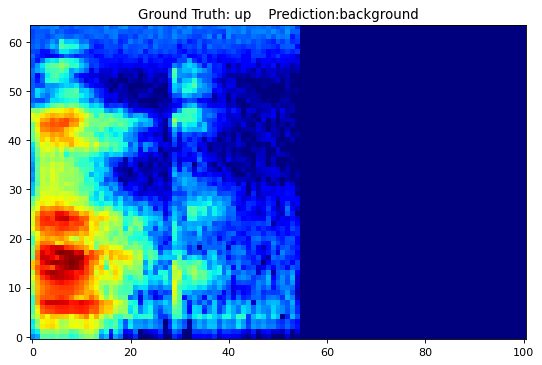

In [20]:
# VISUALIZE SOME EXAMPLES
def visualize_file_prediction(file, evalSC, padLR=False):
    (X,y) = scd.get_file_features(file,padLR=padLR)
    (pred, conf)=evalSC.predictClass(X)
    fig=plt.figure(figsize=(8, 12), dpi=80)
    plt.tight_layout()
    plt.imshow(torch.squeeze(X), cmap='jet', origin='lower')
    plt.title(f'Ground Truth: {scd.KNOWN_COMMANDS[int(y)]}    Prediction:{scd.KNOWN_COMMANDS[pred]}')
    
visualize_file_prediction(testFiles[-2], evalSCq)

What if the speech was more centered? Would the prediction change? Let see.

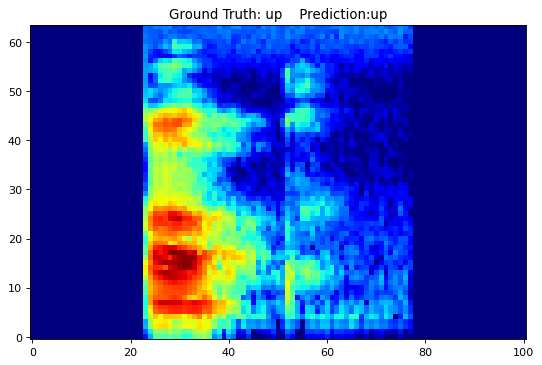

In [21]:
visualize_file_prediction(testFiles[-2], evalSCq, padLR=True)

In [23]:
for file in testFiles:
    (X,y) = scd.get_file_features(file, padLR=True)
    (pred, conf)=evalSCq.predictClass(X)
    if pred == y:
        print(f'\033[1;30;47m Ground Truth = {y} \tPrediction = {pred}   \tConfidence={conf * 100 :.2f}%')
    else:
        print(f'\033[1;30;41m Ground Truth = {y} \tPrediction = {pred}   \tConfidence={conf * 100 :.2f}%')


 Ground Truth = 4 	Prediction = 4   	Confidence=99.95%
 Ground Truth = 10 	Prediction = 10   	Confidence=99.91%
 Ground Truth = 8 	Prediction = 8   	Confidence=100.00%
 Ground Truth = 10 	Prediction = 10   	Confidence=83.48%
 Ground Truth = 3 	Prediction = 3   	Confidence=99.73%
 Ground Truth = 10 	Prediction = 10   	Confidence=99.49%
 Ground Truth = 10 	Prediction = 10   	Confidence=99.83%
 Ground Truth = 1 	Prediction = 1   	Confidence=98.30%
 Ground Truth = 7 	Prediction = 7   	Confidence=99.97%
 Ground Truth = 9 	Prediction = 9   	Confidence=100.00%
 Ground Truth = 10 	Prediction = 10   	Confidence=99.73%
 Ground Truth = 0 	Prediction = 0   	Confidence=100.00%
 Ground Truth = 10 	Prediction = 10   	Confidence=99.26%
 Ground Truth = 10 	Prediction = 10   	Confidence=99.59%
 Ground Truth = 5 	Prediction = 5   	Confidence=99.99%
 Ground Truth = 6 	Prediction = 6   	Confidence=99.69%
 Ground Truth = 10 	Prediction = 10   	Confidence=97.21%
 Ground Truth = 10 	Prediction = 10   	Confide

## Conclusion

Quantizing to 8-bit parameters is a great thing to do for our pre-trained speech commands model. 

We also noticed the fragility of the model to where in the spectrogram the word is. This may not be an issue in practice, as the model may be run multiple times a second on overlapping data. Yet, it shows that there is more work to do on getting a more invariant representation. We see the need for more tools to perform sensitivity analysis to noise and perturbations like time shift. And the need to understand why the model is getting confused by using model interpretability libraries like [Captum](https://captum.ai). These will be topics for a future post. 
